In [1]:
import numpy as np
import tensorflow as tf  # For importing data
import matplotlib.pyplot as plt

#### 1.1.1 

We begin with importing and reshaping the data, so that each image is a vector with $784$ entries instead of a $28 \times 28$ matrix.

In [2]:
# Import data
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    # convert labels to categorical samples
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
    return ((x_train, y_train), (x_test, y_test))

(x_train, y_train), (x_test, y_test) = load_data()
# Reshape data
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

We now perform a multi-layer perceptron consisting of an input layer, five hidden layers with $400$ neurons each and an output layer with $10$ neurons, one for each class. 

![](https://i.imgur.com/F7Yjx6u.png)

We start with description of the forward pass.

The input layer is a matrix with shape $N \times 784$, where $N$ is the size of the batch of images that we pass through the network. We then pass $H_0$ to the first hidden layer 
\begin{equation}
A_1 = H_0 W_0 + B_0,
\end{equation}
where $W_0$ is a matrix $784 \times 400$ denoting our first matrix of weights, $B_0$ is the bias matrix $784 \times 400$ with each row the same and equal to the bias vector $1 \times 400$ since we apply the same bias for each image. After we have obtained $A_1$, we apply the activation function to obtain $H_1$ which in our case is the Leaky ReLu. We repeat the process for each of the hidden layers and then we obtain $A_6$ in the output layer the same way with weights $W_5$ and biases $B_5$, however note that now $A_6$ has dimensions $N \times 10$ as we have only $10$ categories. To obtain $H_6$, we use the softmax function, and $H_6$ is our prediction which we denote by $\hat{Y}$.

After we have obtained our predictions, we compute the errors starting from the output layer and proceeding backward. The first errors are given by
\begin{equation}
\delta^{L+1} = \frac{\hat{Y} - Y}{N}
\end{equation}
which is because we use categorical cross-entropy as our loss function. Then we iteratively update
\begin{equation}
\delta^k = \delta^{k+1} W_k^T \sigma'(A_k).
\end{equation}
From the errors, we compute the changes in $W$ and $B$ as follows:
\begin{align}
& \frac{\partial L}{\partial W_k} = H_k \delta_{k+1}  \\
& \frac{\partial L}{\partial B_k} = \delta_{k+1}
\end{align}
After we have obtained our changes of parameters, we update them according to the Stochastic gradient descent algorithm:
\begin{equation}
\theta_{t+1} = \theta_t - \eta * \text{Changes in parameter},
\end{equation}
where $\theta$ represents each of our parameters. The stochastic part is that we compute the changes over a batch of the whole data, which is picked at random every time when training. 

The final function in our class is the training function, which for each of the $40$ epochs first shuffles and splits the training sets randomly into batches with $256$ points, then performes the Stochastic gradient descent algorithm on these batches (i.e. uses our forward pass, backpropagation and updates the parameters) and finally computes the accuracies and the losses for both the training and test sets for each epoch.

In [4]:
class Neural_Network():

    def __init__(self, epochs, learning_rate):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.parameters = self.initialise_parameters()

    def initialise_parameters(self):

        # Initialise parameters from standard normal distribution
        parameters = {
            'W0': np.random.randn(784, 400) * np.sqrt(2. / (400 + 784)),
            'B0': np.zeros(400),

            'W1': np.random.randn(400, 400) * np.sqrt(2. / (400 + 400)),
            'B1': np.zeros(400),
        
            'W2': np.random.randn(400, 400) * np.sqrt(2. / (400 + 400)),
            'B2': np.zeros(400),

            'W3': np.random.randn(400, 400) * np.sqrt(2. / (400 + 400)),
            'B3': np.zeros(400),

            'W4': np.random.randn(400, 400) * np.sqrt(2. / (400 + 400)),
            'B4': np.zeros(400),

            'W5': np.random.randn(400, 10) * np.sqrt(2. / (10 + 400)),
            'B5': np.zeros(10)
        }

        return parameters

    # Define activation function
    def LeakyReLu(self, x, derivative=False):
      '''
      Return the Leaky ReLU of x.
      If derivative=True, return the derivative of the activation function.
      '''
      if derivative:
        dx = np.ones_like(x)
        dx[x < 0] = 0.01
        return dx
      return np.where(x > 0, x, x * 0.01)


    def softmax(self, x):
      '''
      Apply Softmax activation to x.
      '''

      return np.exp(x - x.max(axis=1, keepdims=True)) / np.exp(x - x.max(axis=1, keepdims=True)).sum(axis=1, keepdims=True)
    
    # Forward pass
    def forward_pass(self, x_train):
        '''
        Perform forward pass through the network.
        Input:
          x_train: batch of training samples
        Output:
          Returns the produced outputs.
        '''

        # Input layer
        self.parameters['H0'] = x_train

        # Calculate A1 and H1
        self.parameters['A1'] = np.dot(self.parameters['H0'], self.parameters['W0']) + self.parameters['B0']
        self.parameters['H1'] = self.LeakyReLu(self.parameters['A1'])

        # Calculate A2 and H2
        self.parameters['A2'] = np.dot(self.parameters['H1'], self.parameters['W1']) + self.parameters['B1']
        self.parameters['H2'] = self.LeakyReLu(self.parameters['A2'])

        # Calculate A3 and H3
        self.parameters['A3'] = np.dot(self.parameters['H2'], self.parameters['W2']) + self.parameters['B2']
        self.parameters['H3'] = self.LeakyReLu(self.parameters['A3'])

        # Calculate A4 and H4
        self.parameters['A4'] = np.dot(self.parameters['H3'], self.parameters['W3']) + self.parameters['B3']
        self.parameters['H4'] = self.LeakyReLu(self.parameters['A4'])

        # Calculate A5 and H5
        self.parameters['A5'] = np.dot(self.parameters['H4'], self.parameters['W4']) + self.parameters['B4']
        self.parameters['H5'] = self.LeakyReLu(self.parameters['A5'])

        # Calculate A6 and Y_hat
        self.parameters['A6'] = np.dot(self.parameters['H5'], self.parameters['W5']) + self.parameters['B5']
        self.parameters['Y_hat'] = self.softmax(self.parameters['A6'])

        # Return outcomes
        return self.parameters['Y_hat']

    
    # Backward pass
    def backpropagation(self, y_train, y_hat):
      '''
      Perform backpropagation through the network.
      Input:
        y_train: true labels
        y_hat: predicted labels
      Output: 
        Returns dictionaries containing the changes in the parameters W and B.
      '''

      parameters = self.parameters

      # Dictionaries to store the changes in W and B
      W_updates = {}
      B_updates = {}

      # Compute the error for the output layer
      error = (y_hat - y_train) / y_train.shape[0]
      # Updates on W5 and B4
      W_updates['W5'] = np.dot(parameters['H5'].T, error)
      B_updates['B5'] = np.dot(np.ones(error.shape[0]), error)  # make it a matrix so that we add b for each image

      # Update the error for the next layers and compute the changes in W and B
      error = np.dot(error, parameters['W5'].T) * self.LeakyReLu(parameters['A5'], derivative=True)
      W_updates['W4'] = np.dot(parameters['H4'].T, error)
      B_updates['B4'] = np.dot(np.ones(error.shape[0]), error)

      # Updates on W3 and B3
      error = np.dot(error, parameters['W4'].T) * self.LeakyReLu(parameters['A4'], derivative=True)
      W_updates['W3'] = np.dot(parameters['H3'].T, error)
      B_updates['B3'] = np.dot(np.ones(error.shape[0]), error)

      # Updates on W2 and B2
      error = np.dot(error, parameters['W3'].T) * self.LeakyReLu(parameters['A3'], derivative=True)
      W_updates['W2'] = np.dot(parameters['H2'].T, error)
      B_updates['B2'] = np.dot(np.ones(error.shape[0]), error)

      # Updates on W1 and B1
      error = np.dot(error, parameters['W2'].T) * self.LeakyReLu(parameters['A2'], derivative=True)
      W_updates['W1'] = np.dot(parameters['H1'].T, error)
      B_updates['B1'] = np.dot(np.ones(error.shape[0]), error)

      # Updates on W0 and B0
      error = np.dot(error, parameters['W1'].T) * self.LeakyReLu(parameters['A1'], derivative=True)
      W_updates['W0'] = np.dot(parameters['H0'].T, error)
      B_updates['B0'] = np.dot(np.ones(error.shape[0]), error)

      return W_updates, B_updates
  

    def update_parameters(self, W_updates, B_updates):
      '''
      Update all weights and bias parameters using the gradient descent method.
      Input:
        W_updates: a dictionary with the changes for each W.
        B_updates: a dictionary with the changes for each B.
      '''

      # Update all weights
      for W, change_in_W in W_updates.items():
        self.parameters[W] -= self.learning_rate * change_in_W

      # Update all biases
      for B, change_in_B in B_updates.items():
        self.parameters[B] -= self.learning_rate * change_in_B
    

    # Function computing the loss
    def loss(self, y_true, y_hat):
      '''
      Compute the loss of our model using categorical cross-entropy.
      Input:
        y_true: true labels
        y_hat: predicted labels
      Output:
        Returns the categorical cross entropy loss.
      '''

      return -np.mean(y_true * np.log(y_hat))


    # Function computing the accuracy
    def accuracy(self, y_true, y_hat):
        '''
        Compute the accuracy of our model
        Inputs:
          y_true: true labels
          y_hat: predicted labels
        Output:
          Returns the accuracy of the model
        '''

        # Prediction for the label
        prediction = y_hat.argmax(axis=1).squeeze()
        # True label
        true_labels = y_true.argmax(axis=1).squeeze()
        
        # Return the accuracy
        return np.mean((prediction == true_labels))
    

    # Train the model
    def train(self, x_train, y_train, x_test, y_test, printing=False):
      '''
      Input:
        x_train: training inputs
        y_train: true labels for the training set
        x_test: testing inputs
        y_test: true labels for the testing set
      Output:
        train_accuracies: Accuracies for all epochs on tha training set
        test_accuracies: Accuracies for all epochs on tha testing set
        train_losses: Losses for all epochs on tha training set
        test_losses: Losses for all epochs on tha testing set
      '''
      train_accuracies = []
      test_accuracies = []
      train_losses = []
      test_losses = []

      for epoch in range(self.epochs):
    
        # Random permutation of the indices
        p = np.random.permutation(len(x_train))
        
        # Split into batches of 256 data points
        x_batches = np.array_split(x_train[p], len(x_train) // 256 + 1)
        y_batches = np.array_split(y_train[p], len(x_train) // 256 + 1)

        # Stochastic Gradient Descent
        for i in range(len(x_batches)):

          # Compute prediction for each batch
          y_hat = self.forward_pass(x_batches[i])
          # Compute changes in parameters and update the parameters
          W_updates, B_updates = self.backpropagation(y_batches[i], y_hat)
          self.update_parameters(W_updates, B_updates)
        
        # Compute the accuracy and loss on the training set for this epoch
        y_train_predictions = self.forward_pass(x_train)
        # Append values to list
        train_accuracies.append(self.accuracy(y_train, y_train_predictions))
        train_losses.append(self.loss(y_train, y_train_predictions))

        # Repeat for the test set
        y_test_prediction = self.forward_pass(x_test)
        test_accuracies.append(self.accuracy(y_test, y_test_prediction))
        test_losses.append(self.loss(y_test, y_test_prediction))

        # Print accuracies for each epoch
        if printing:
          print(f'Epoch:{epoch+1}/{self.epochs}',
                f'Accuracy on training set: {train_accuracies[-1]*100:.2f}%',
                f'Accuracy on test set: {test_accuracies[-1]*100:.2f}%')

      # Return the accuracies and losses for both the validation and training sets
      return train_accuracies, test_accuracies, train_losses, test_losses

Now we train the MLP using $40$ epochs and learning rate of $10^{-3}$.

In [5]:
# Create MLP with 40 epochs and 0.001 learning rate
neural_network = Neural_Network(epochs=40, learning_rate=0.001)

# Train the model
train_accuracies, test_accuracies, train_losses, test_losses = neural_network.train(x_train, 
                                                                                    y_train, 
                                                                                    x_test, 
                                                                                    y_test, 
                                                                                    printing=True)

Epoch:1/40 Accuracy on training set: 34.30% Accuracy on test set: 34.39%
Epoch:2/40 Accuracy on training set: 43.53% Accuracy on test set: 42.99%
Epoch:3/40 Accuracy on training set: 47.58% Accuracy on test set: 46.89%
Epoch:4/40 Accuracy on training set: 53.44% Accuracy on test set: 52.71%
Epoch:5/40 Accuracy on training set: 60.46% Accuracy on test set: 59.72%
Epoch:6/40 Accuracy on training set: 63.83% Accuracy on test set: 63.26%
Epoch:7/40 Accuracy on training set: 66.00% Accuracy on test set: 65.03%
Epoch:8/40 Accuracy on training set: 67.63% Accuracy on test set: 66.65%
Epoch:9/40 Accuracy on training set: 68.69% Accuracy on test set: 67.57%
Epoch:10/40 Accuracy on training set: 69.87% Accuracy on test set: 68.65%
Epoch:11/40 Accuracy on training set: 71.50% Accuracy on test set: 70.31%
Epoch:12/40 Accuracy on training set: 73.15% Accuracy on test set: 71.79%
Epoch:13/40 Accuracy on training set: 73.69% Accuracy on test set: 72.29%
Epoch:14/40 Accuracy on training set: 73.95% Ac

Now we create two plots - one for the loss and the other for the accuracy for each epoch, comparing the performance on the training and test sets.

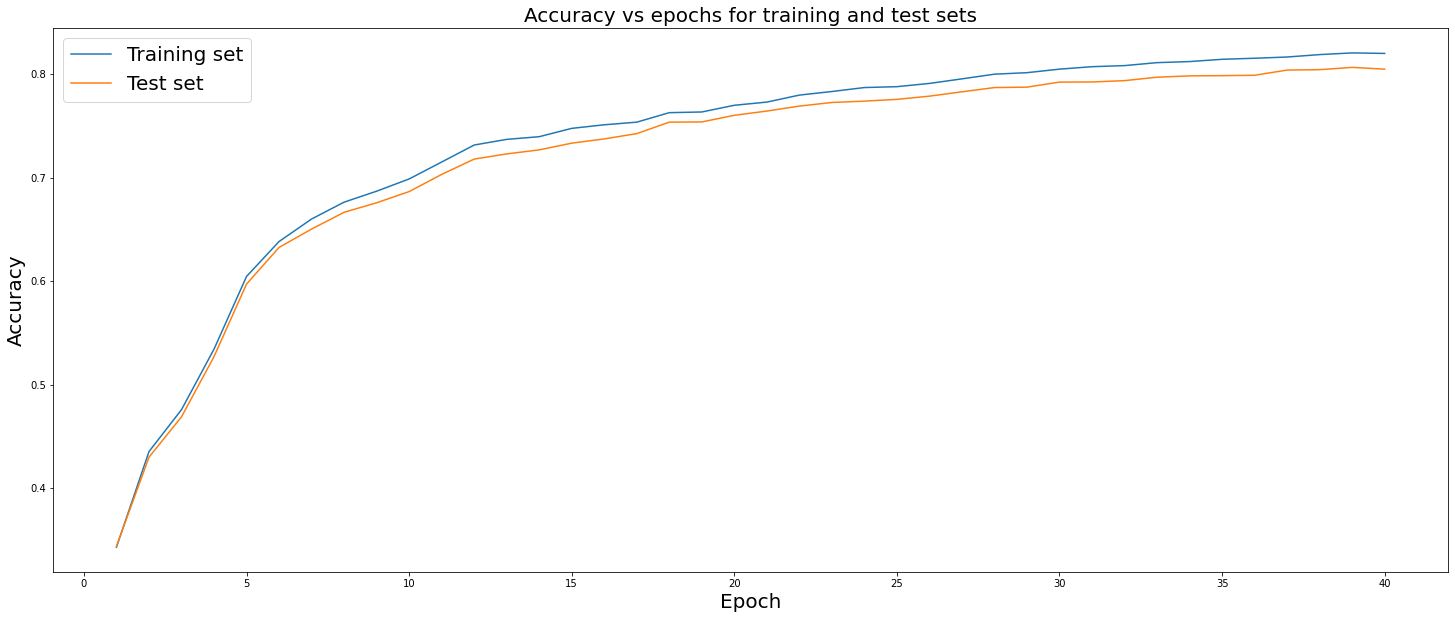

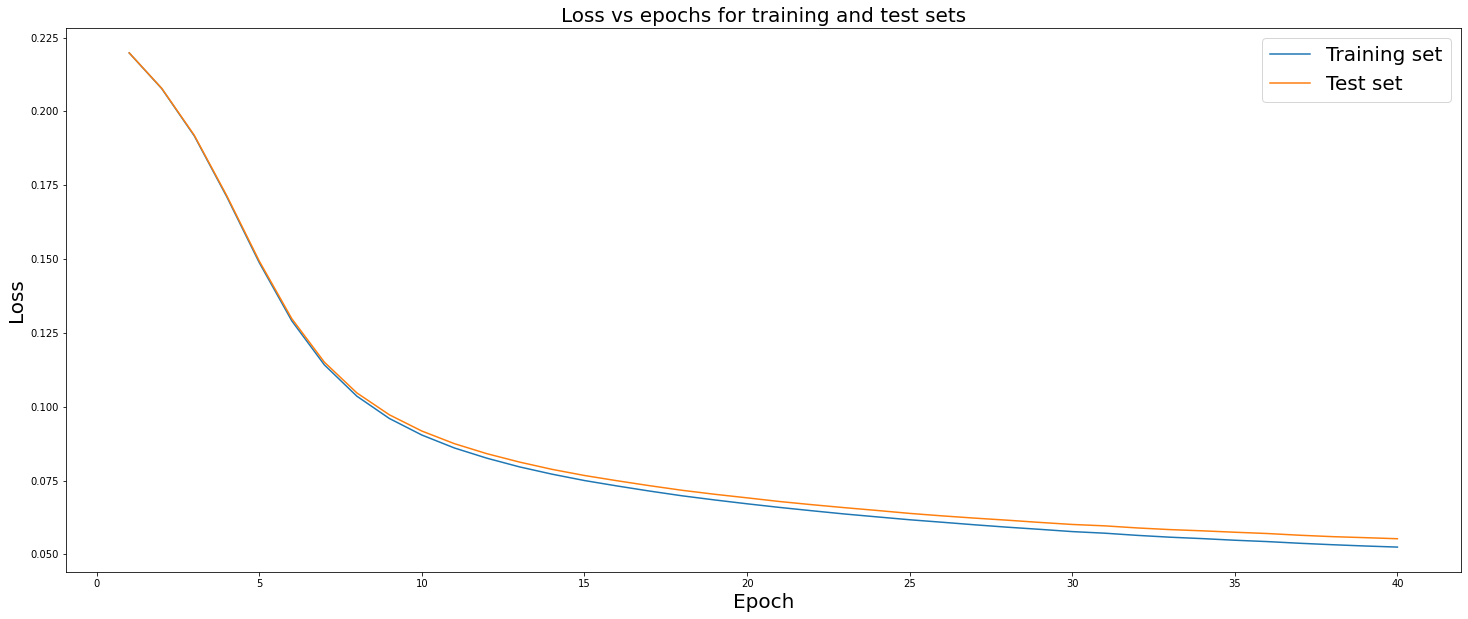

In [6]:
# Plot for accuracies
plt.figure(figsize=(25,10))
plt.plot(np.arange(1,41), train_accuracies, label="Training set")
plt.plot(np.arange(1,41), test_accuracies, label="Test set")
plt.title("Accuracy vs epochs for training and test sets", size=20)
plt.xlabel("Epoch", size=20)
plt.ylabel("Accuracy", size=20)
plt.legend(fontsize=20)
plt.show()

# Plot for loss
plt.figure(figsize=(25,10))
plt.plot(np.arange(1,41), train_losses, label="Training set")
plt.plot(np.arange(1,41), test_losses, label="Test set")
plt.title("Loss vs epochs for training and test sets", size=20)
plt.xlabel("Epoch", size=20)
plt.ylabel("Loss", size=20)
plt.legend(fontsize=20)
plt.show()

Overall, we can see that the accuracy on both the validation and testing set increases as we increase the number of epochs and the loss decreases, as expected. During the first few epochs, the accuracy and loss for both sets seems almost identical. As we increase the number of epochs however, the accuracy on the testing set seems to become a bit less than that on the training set, suggesting a slight overfitting of the model (and similarly for the loss).